In [1]:
import torch 
import numpy as np
from torchvision import models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
from torchsummary import summary
from tqdm import tqdm
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d

import transform
import mydataset

C:\Users\Administrator\anaconda3\envs\box\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = models.vgg16(pretrained=True)

C:\Users\Administrator\anaconda3\envs\box\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Administrator\anaconda3\envs\box\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [211]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# ???????????
for param in model.parameters():
    param.requires_grad = False

In [5]:
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer


final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.7),
    nn.Linear(300, 8),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [6]:
model = model.to(device)

In [216]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
# getting the optimizer and loss_function 
def get_essentials():  
    loss_fun = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return loss_fun, optimizer

In [8]:
def train_batch(data, model, loss_fun, optimizer):
    model.train()
    img = data['image']
    true_points = data ['keypoints']
    true_points = true_points.type(torch.FloatTensor)
    true_points=true_points.flatten()
    #print(true_points.shape)
    img = img.type(torch.FloatTensor)
    #print(img.shape)
    pred_points = model(img)
    pred_points=pred_points.flatten()
    #print(pred_points.shape)
    loss_val = loss_fun(pred_points, true_points)
    loss_val.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss_val.item()

In [9]:
@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
    model.eval()
    img = data['image']
    true_points = data ['keypoints']
    true_points = true_points.type(torch.FloatTensor)
    true_points=true_points.flatten()
    img = img.type(torch.FloatTensor)

    pred_points = model(img)
    pred_points=pred_points.flatten()
  
    loss_val = loss_fun(pred_points, true_points)
    return loss_val.item()

In [10]:
epochs = 20
loss_fun, optimizer = get_essentials()

In [11]:
DIR = r'C:\\Users\Administrator\Desktop\AIOR_Group\\Project1\src\box_dataset'
triandataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'train')
testdataobj = mydataset.MyDataset(img_dir = DIR, annotation_file = 'dataset.json', transform = transform.data_transform, datatype = 'test')

train_dataloader = DataLoader(triandataobj, batch_size=20, shuffle=True)
test_dataloader = DataLoader(testdataobj, batch_size=20, shuffle=True)

In [12]:
train_epoch, val_epoch = [], []

for epoch in tqdm(range(epochs)):
    train_batch_losses, val_batch_losses = [], []
    for data in train_dataloader:
        train_batch_loss = train_batch(data, model, loss_fun, optimizer)
        train_batch_losses.append(train_batch_loss)

    for data in test_dataloader:
        val_batch_loss = val_batch(data, model, loss_fun, optimizer)
        val_batch_losses.append(val_batch_loss)
    train_epoch.append(np.mean(train_batch_losses))
    val_epoch.append(np.mean(val_batch_losses))

100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [35:18<00:00, 105.92s/it]


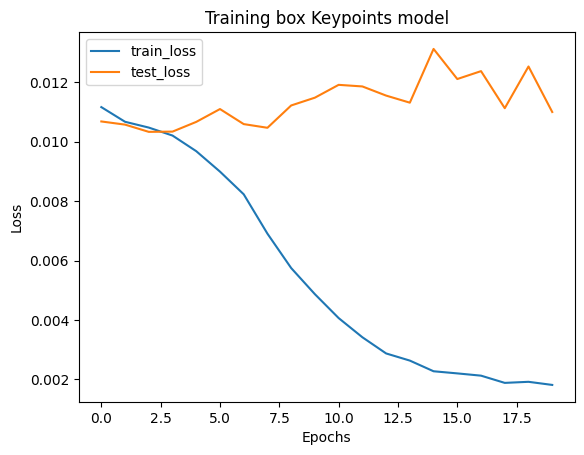

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training box Keypoints model")
plt.show()

In [195]:
idx = 10
img = testdataobj[idx]['image']
true_points = testdataobj[idx]['keypoints']
true_points = true_points.type(torch.FloatTensor)
img = img.type(torch.FloatTensor)
print(type(img))
print(img.shape)
pred_points = model(img[None])
pred_points = pred_points.flatten()
#true_points = true_points.flatten()
print(pred_points)
print(true_points)







<class 'torch.Tensor'>
torch.Size([3, 256, 256])
tensor([0.4555, 0.5501, 0.4672, 0.4716, 0.5354, 0.4386, 0.5461, 0.5445],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[0.4230, 0.6111],
        [0.4140, 0.3957],
        [0.5770, 0.3889],
        [0.5860, 0.6043]])


[[0.42298338 0.6111093 ]
 [0.41403586 0.3956592 ]
 [0.5770166  0.38889068]
 [0.58596414 0.6043408 ]]
tensor([[[0.4555, 0.5501],
         [0.4672, 0.4716],
         [0.5354, 0.4386],
         [0.5461, 0.5445]]])


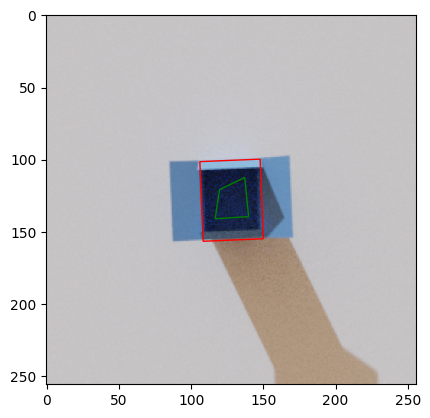

In [196]:
from matplotlib.patches import Polygon
import matplotlib.patches as patches


fig, ax = plt.subplots()

imag = img.squeeze().numpy()     
imag = imag.transpose((1, 2, 0))                
ax.imshow(imag)
corners = np.array(true_points)

print (corners)
corners = np.multiply(corners,256)
corners=corners.squeeze()
P1 = patches.Polygon(corners, linewidth=1, edgecolor='r', facecolor='none')

pred_points=torch.reshape(pred_points,(1,4,2))
corners = pred_points.detach()
corners.shape

print (corners)
corners = np.multiply(corners,256)
corners=corners.squeeze()
P2 = patches.Polygon(corners, linewidth=1, edgecolor='g', facecolor='none')


ax.add_patch(P1)
ax.add_patch(P2)
plt.show()


In [143]:
pred_points.shape
pred_points=torch.reshape(pred_points,(1,4,2))

In [144]:
pred_points


tensor([[[0.3567, 0.4404],
         [0.5879, 0.4120],
         [0.6244, 0.5489],
         [0.4350, 0.6054]]], grad_fn=<ReshapeAliasBackward0>)

In [ ]:
true_points

tensor([[[0.3984, 0.5182],
         [0.4856, 0.3978],
         [0.6016, 0.4818],
         [0.5144, 0.6022]]])

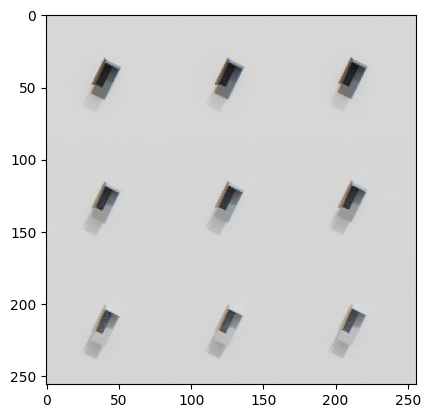

In [ ]:
plt.imshow(img)